# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

THis particular notebook will use the [SIDES simulation](http://cesam.lam.fr/sides/) from [Bethermin et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...607A..89B/abstract) to test how well the XID+SED CIGALE model recovers the true parameters

In [1]:

field=['Lockman-SWIRE']
path_to_SPIRE=['/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/']
#path_to_SPIRE=['/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/']
redshift_file=["/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]
#redshift_file=["/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]

Import required modules

In [2]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
try:
    source=[np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[0]

Set image and catalogue filenames

In [4]:
#Folder containing maps
pswfits=path_to_SPIRE[0]+'{}_SPIRE250_v1.0.fits'.format(field[0])#SPIRE 250 map
pmwfits=path_to_SPIRE[0]+'{}_SPIRE350_v1.0.fits'.format(field[0])#SPIRE 350 map
plwfits=path_to_SPIRE[0]+'{}_SPIRE500_v1.0.fits'.format(field[0])#SPIRE 500 map




#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [5]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[3].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[3].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[3].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

XID+ uses Multi Order Coverage (MOC) maps for cutting down maps and catalogues so they cover the same area. It can also take in MOCs as selection functions to carry out additional cuts. Lets use the python module [pymoc](http://pymoc.readthedocs.io/en/latest/) to create a MOC, centered on a specific position we are interested in. We will use a HEALPix order of 15 (the resolution: higher order means higher resolution)

Read in the SIDES catalogue

In [73]:
from astropy.io import fits
Mock=fits.open('../../../data/Mock_cat_Bethermin2017.fits',format='fits')


In [74]:
import pandas as pd
cols=['REDSHIFT','RA','DEC','SFR','SMIPS24','SSPIRE250','SSPIRE350','SSPIRE500']
Mock=pd.DataFrame(np.vstack([Mock[1].data[c].reshape(-1) for c in cols]).T,columns=cols)
Mock=Mock[Mock['SMIPS24']>5E-6]
Mock=Mock.reset_index(drop=True)


In [76]:
Mock[0:5]

,REDSHIFT,RA,DEC,SFR,SMIPS24,SSPIRE250,SSPIRE350,SSPIRE500
0,0.028948,0.653517,1.053531,1.543751,0.031882,0.256333,0.104620,0.037054
1,0.027158,0.931048,0.651234,0.385166,0.006702,0.096441,0.041178,0.015021
2,0.028611,0.787421,0.940826,0.234264,0.004684,0.044218,0.018422,0.006612
3,0.030565,1.024233,1.341723,0.129941,0.002256,0.011491,0.004300,0.001439
4,0.027382,1.168631,0.542636,0.066786,0.001146,0.016499,0.007045,0.002570


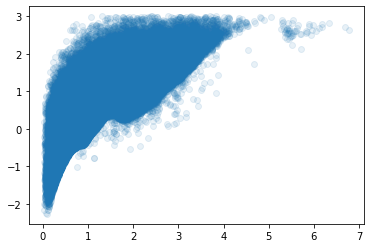

In [77]:
plt.plot(Mock['REDSHIFT'],np.log10(Mock['SFR']),'o',alpha=0.1)

## Create empty maps

In [78]:
maps=[fits.HDUList([fits.PrimaryHDU(np.zeros((np.ceil(1.5/(p/3600.0)).astype(int),np.ceil(1.5/(p/3600.0)).astype(int)))),
                    fits.PrimaryHDU(np.ones((np.ceil(1.5/(p/3600.0)).astype(int),np.ceil(1.5/(p/3600.0)).astype(int)))*np.nanmedian(m))]) for p,m in zip([pixsize250,pixsize350,pixsize500],[nim250,nim350,nim500])]

In [79]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
for i,h in enumerate([w_250,w_350,w_500]):
    for e in range(0,2):
        ra_obj=0.75
        dec_obj=0.75
        w = wcs.WCS(naxis=2)

        # reference pixel coordinate
        w.wcs.crpix = [int(maps[i][e].data.shape[0]/2),int(maps[i][e].data.shape[1]/2)]

        # sizes of the pixel in degrees
        w.wcs.cdelt = [h.wcs.cd[0,0],h.wcs.cd[1,1]]

        # converting ra and dec into degrees
        c = SkyCoord(ra_obj*u.degree, dec_obj*u.degree)
        w.wcs.crval = [c.ra.deg, c.dec.deg]

        # the units of the axes are in degrees
        #w.wcs.cunit = ['deg', 'deg']
        w.wcs.ctype=['RA---TAN','DEC--TAN']
        wcs_header = w.to_header()


        maps[i][e].header.update(wcs_header)


## Select candidate objects to look at

In [80]:
ind_esb=Mock['SFR']>950

I will look at objects with the highes SFR in the simulation and for each one carry out the type of fit I would do with the real objects i.e.
1. Fit with prior selection
2. Fit removing the candidate

In [88]:
for i in range(0,ind_esb.sum()):
    c = SkyCoord(ra=Mock['RA'][ind_esb].values[i]*u.degree, dec=Mock['DEC'][ind_esb].values[i]*u.degree)
    import pymoc
    moc=pymoc.util.catalog.catalog_to_moc(c,100,15)
    #---prior250--------
    prior250=xidplus.prior(maps[0][0].data,maps[0][1].data,None,maps[0][0].header, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
    prior250.prior_cat(Mock['RA'],Mock['DEC'],'photoz',ID=Mock.index)
    prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
    #---prior350--------
    prior350=xidplus.prior(maps[1][0].data,maps[1][1].data,None,maps[1][0].header, moc=moc)
    prior350.prior_cat(Mock['RA'],Mock['DEC'],'photoz',ID=Mock.index)
    prior350.prior_bkg(-5.0,5)
    #---prior500--------
    prior500=xidplus.prior(maps[2][0].data,maps[2][1].data,None,maps[2][0].header, moc=moc)
    prior500.prior_cat(Mock['RA'],Mock['DEC'],'photoz',ID=Mock.index)
    prior500.prior_bkg(-5.0,5)
    
    #pixsize array (size of pixels in arcseconds)
    pixsize=np.array([pixsize250,pixsize350,pixsize500])
    #point response function for the three bands
    prfsize=np.array([18.15,25.15,36.3])
    #use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
    from astropy.convolution import Gaussian2DKernel

    ##---------fit using Gaussian beam-----------------------
    prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
    prf250.normalize(mode='peak')
    prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
    prf350.normalize(mode='peak')
    prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
    prf500.normalize(mode='peak')

    pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
    pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
    pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

    prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
    prior350.set_prf(prf350.array,pind350,pind350)
    prior500.set_prf(prf500.array,pind500,pind500)
    
    print('fitting '+ str(prior250.nsrc)+' sources \n')
    print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')
    print('source density = {}'.format(prior250.nsrc/moc.area_sq_deg))
    
    #prior24.get_pointing_matrix()
    prior250.get_pointing_matrix()
    prior350.get_pointing_matrix()
    prior500.get_pointing_matrix()
    
    bkg=[-5,-6,-7]
    prior250.sim=xidplus.posterior_maps.ymod_map(prior250,Mock['SSPIRE250'][prior250.ID]*1000.0).reshape(-1)+bkg[0]+np.random.normal(scale=prior250.snim)
    prior350.sim=xidplus.posterior_maps.ymod_map(prior350,Mock['SSPIRE350'][prior250.ID]*1000.0).reshape(-1)+bkg[1]+np.random.normal(scale=prior350.snim)
    prior500.sim=xidplus.posterior_maps.ymod_map(prior500,Mock['SSPIRE500'][prior250.ID]*1000.0).reshape(-1)+bkg[2]+np.random.normal(scale=prior500.snim)
    
    xidplus.save([prior250,prior350,prior500],None,'SIDES_Sim_test_{}_full'.format(i))
    Mock.loc[prior250.ID.values].to_csv('prior_list_SIDES_sim_test_{}_full.csv'.format(i))

fitting 273 sources 

using 879, 455 and 226 pixels
source density = 112195.397579633
fitting 293 sources 

using 877, 453 and 219 pixels
source density = 120573.48995464765
fitting 279 sources 

using 873, 455 and 219 pixels
source density = 114812.29930835051
fitting 287 sources 

using 873, 452 and 221 pixels
source density = 118104.40824909172
fitting 379 sources 

using 870, 447 and 216 pixels
source density = 156375.71829632827
fitting 319 sources 

using 874, 457 and 221 pixels
source density = 131446.02718357652
fitting 237 sources 

using 870, 454 and 221 pixels
source density = 98175.46959339443
fitting 340 sources 

using 879, 447 and 217 pixels
source density = 139546.91741913315
fitting 289 sources 

using 871, 449 and 220 pixels
source density = 119399.3697520718
fitting 289 sources 

using 872, 456 and 216 pixels
source density = 119084.33183715868
fitting 289 sources 

using 875, 450 and 224 pixels
source density = 119399.3697520718
fitting 280 sources 

using 865, 453 

In [87]:
for i in range(0,ind_esb.sum()):
    c = SkyCoord(ra=Mock['RA'][ind_esb].values[i]*u.degree, dec=Mock['DEC'][ind_esb].values[i]*u.degree)
    import pymoc
    moc=pymoc.util.catalog.catalog_to_moc(c,100,15)
    sep = 18
    separation = c.separation(SkyCoord(Mock['RA'].values*u.degree, Mock['DEC'].values*u.degree)).arcsec
    remove_ind = (separation > np.min(separation)) & (separation < sep)
    
    Mock_drop=Mock.drop(np.arange(0,len(Mock))[remove_ind])
    
    #---prior250--------
    prior250=xidplus.prior(maps[0][0].data,maps[0][1].data,None,maps[0][0].header, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
    prior250.prior_cat(Mock_drop['RA'],Mock_drop['DEC'],'photoz',ID=Mock_drop.index)
    prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
    #---prior350--------
    prior350=xidplus.prior(maps[1][0].data,maps[1][1].data,None,maps[1][0].header, moc=moc)
    prior350.prior_cat(Mock_drop['RA'],Mock_drop['DEC'],'photoz',ID=Mock_drop.index)
    prior350.prior_bkg(-5.0,5)
    #---prior500--------
    prior500=xidplus.prior(maps[2][0].data,maps[2][1].data,None,maps[2][0].header, moc=moc)
    prior500.prior_cat(Mock_drop['RA'],Mock_drop['DEC'],'photoz',ID=Mock_drop.index)
    prior500.prior_bkg(-5.0,5)
    
    #pixsize array (size of pixels in arcseconds)
    pixsize=np.array([pixsize250,pixsize350,pixsize500])
    #point response function for the three bands
    prfsize=np.array([18.15,25.15,36.3])
    #use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
    from astropy.convolution import Gaussian2DKernel

    ##---------fit using Gaussian beam-----------------------
    prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
    prf250.normalize(mode='peak')
    prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
    prf350.normalize(mode='peak')
    prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
    prf500.normalize(mode='peak')

    pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
    pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
    pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

    prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
    prior350.set_prf(prf350.array,pind350,pind350)
    prior500.set_prf(prf500.array,pind500,pind500)
    
    print('fitting '+ str(prior250.nsrc)+' sources \n')
    print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')
    print('source density = {}'.format(prior250.nsrc/moc.area_sq_deg))
    
    #prior24.get_pointing_matrix()
    prior250.get_pointing_matrix()
    prior350.get_pointing_matrix()
    prior500.get_pointing_matrix()
    
    bkg=[-5,-6,-7]
    prior250.sim=xidplus.posterior_maps.ymod_map(prior250,Mock['SSPIRE250'][prior250.ID]*1000.0).reshape(-1)+bkg[0]+np.random.normal(scale=prior250.snim)
    prior350.sim=xidplus.posterior_maps.ymod_map(prior350,Mock['SSPIRE350'][prior250.ID]*1000.0).reshape(-1)+bkg[1]+np.random.normal(scale=prior350.snim)
    prior500.sim=xidplus.posterior_maps.ymod_map(prior500,Mock['SSPIRE500'][prior250.ID]*1000.0).reshape(-1)+bkg[2]+np.random.normal(scale=prior500.snim)
    
    xidplus.save([prior250,prior350,prior500],None,'SIDES_Sim_test_{}_alt'.format(i))
    Mock.loc[prior250.ID.values].to_csv('prior_list_SIDES_sim_test_{}_alt.csv'.format(i))

fitting 258 sources 

using 879, 455 and 226 pixels
source density = 106030.81529503778
fitting 286 sources 

using 877, 453 and 219 pixels
source density = 117692.89463149908
fitting 267 sources 

using 873, 455 and 219 pixels
source density = 109874.13589723867
fitting 278 sources 

using 873, 452 and 221 pixels
source density = 114400.78569075784
fitting 363 sources 

using 870, 447 and 216 pixels
source density = 149774.10485901625
fitting 301 sources 

using 874, 457 and 221 pixels
source density = 124029.0099757258
fitting 230 sources 

using 870, 454 and 221 pixels
source density = 95275.77217924355
fitting 326 sources 

using 879, 447 and 217 pixels
source density = 133800.86787834534
fitting 279 sources 

using 871, 449 and 220 pixels
source density = 115267.90367068523
fitting 284 sources 

using 872, 456 and 216 pixels
source density = 117024.04927942237
fitting 279 sources 

using 875, 450 and 224 pixels
source density = 115267.90367068523
fitting 271 sources 

using 865, 4